In [ ]:
import sqlite3 as db
import pandas as pd
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.transform import factor_cmap
from bokeh.io import output_notebook

In [ ]:
df = pd.read_csv('/Users/dariushammond/Desktop/Desktop/Projects/Bank Failures/bank-data.csv')

disk_engine = db.connect('bank_failures.db')

c = disk_engine.cursor()
df.to_sql("bankfailures", disk_engine, if_exists='replace', index=False)


3548

# Bank Failures Dataset

## Columns and Descriptions

1. **Institution Name**
   - **Description:** The name of the failed bank.
   
2. **Cert**
   - **Description:** The unique certificate number assigned to the bank by the FDIC.
   
3. **FIN**
   - **Description:** The Federal Information Number, a unique identifier for financial institutions.
   
4. **Location**
   - **Description:** The city and state where the bank was headquartered.
   
5. **Effective Date**
   - **Description:** The date when the bank failure was officially recorded.
   
6. **Insurance Fund**
   - **Description:** The insurance fund responsible for covering the bank's deposits.
   
7. **Resolution**
   - **Description:** The method used to resolve the bank's failure, such as payout or acquisition by another bank.
   
8. **Estimated Loss**
   - **Description:** The estimated financial loss resulting from the bank's failure.
   
9. **Transaction Type**
   - **Description:** The type of transaction used to resolve the bank, such as a purchase and assumption (P&A) or insured deposit transfer (IDT).
   
10. **Charter Class**
    - **Description:** The charter class of the bank, indicating whether it was a national or state-chartered bank.
    
11. **Total Deposits**
    - **Description:** The total amount of deposits held by the bank at the time of its failure.
    
12. **Total Assets**
    - **Description:** The total amount of assets held by the bank at the time of its failure.


In [ ]:
df = pd.read_sql_query('SELECT * FROM BANKFAILURES;', disk_engine)
df.head()

,CERT,CHCLASS1,CITYST,COST,FAILDATE,FIN,ID,NAME,QBFASSET,QBFDEP,RESTYPE,RESTYPE1,SAVR
0,27332,NM,"PHILADELPHIA, PA",NaN,4/26/2024,10546,4110,REPUBLIC BANK,5866190.0,4373927.0,FAILURE,PA,BIF
1,8758,NM,"SAC CITY, IA",14804.0,11/3/2023,10545,4109,CITIZENS BANK,60448.0,52311.0,FAILURE,PA,DIF
2,25851,SM,"ELKHART, KS",54167.0,7/28/2023,10544,4108,HEARTLAND TRI-STATE BANK,139446.0,130110.0,FAILURE,PA,DIF
3,59017,NM,"SAN FRANCISCO, CA",16566779.0,5/1/2023,10543,4107,FIRST REPUBLIC BANK,212638872.0,176436706.0,FAILURE,PA,DIF
4,57053,NM,"NEW YORK, NY",2787270.0,3/12/2023,10540,4106,SIGNATURE BANK,110363650.0,88612911.0,FAILURE,PA,DIF


## Renaming columns
Looking at the dataframe we can see that the column names arent that clear. We can rename the column names in Table by using the **ALTER TABLE** command.

In [ ]:
new_columns_names = [
            ('CHCLASS1', 'CHARTER_CLASS'),
             ('CITYST' , 'CITY_ST'),
             ('COST', 'ESTIMATED_LOSS'),
             ('FAILDATE', 'FAIL_DATE'),
             ('QBFASSET', 'TOTAL_ASSETS'),
             ('QBFDEP', 'TOTAL_DEPOSITS'),
             ('RESTYPE', 'RESOLUTION'),
             ('RESTYPE1', 'TRANSACTION_TYPE'),
             ('SAVR', 'INSURANCE_FUND')]
for old_name, new_name in new_columns_names: 
    c.execute(f'ALTER TABLE BANKFAILURES RENAME COLUMN {old_name} TO {new_name}') #executes query string

    

In [ ]:
#disk_engine.commit() # commit so changes can be perma

# How many banks have failed in this dataset?

In [ ]:
query = '''SELECT COUNT(*) AS number_of_failed_banks
            FROM BANKFAILURES
            
'''
df = pd.read_sql_query(query,disk_engine).rename(columns=str.lower);df.head()

,number_of_failed_banks
0,3548


# What are the unique locations where banks have failed?

In [ ]:
query = '''SELECT DISTINCT city_st
            FROM BANKFAILURES'''
df = pd.read_sql_query(query,disk_engine).rename(columns=str.lower)
print("There are {} unique locations, the first five are:".format(len(df)))
df.head()

There are 1998 unique locations, the first five are:


,city_st
0,"PHILADELPHIA, PA"
1,"SAC CITY, IA"
2,"ELKHART, KS"
3,"SAN FRANCISCO, CA"
4,"NEW YORK, NY"


## Lets see how many by state, whats your guess?

In [ ]:
query = ''' SELECT DISTINCT SUBSTR(city_st,-2) AS State, COUNT(*) AS Count
            FROM BANKFAILURES
            GROUP BY 1
            ORDER BY Count DESC         
            '''
df = pd.read_sql_query(query,disk_engine)
print("There are {} unique States, the first five are:".format(len(df)))
df.head()

There are 53 unique States, the first five are:


,State,Count
0,TX,863
1,CA,259
2,IL,200
3,FL,194
4,OK,169


## We also see the counts for each state and looks like texas has a lot of banks that failed. Lets calculate a Cumulative percentage

In [ ]:
query = '''
        SELECT 
    State, 
    Count, 
    ROUND((Count * 1.0/ (SELECT COUNT(*) FROM BANKFAILURES)) * 100.00000,2) || '%' AS TotalFailuresPercentageByState
FROM (
    SELECT 
        SUBSTR(city_st, -2) AS State, 
        COUNT(*) AS Count
    FROM BANKFAILURES
    GROUP BY SUBSTR(city_st, -2)
)
ORDER BY Count DESC     
 
'''
df = pd.read_sql_query(query,disk_engine)
print("The Top 5 States with the highest percentage of bank failures")

df.head()

The Top 5 States with the highest percentage of bank failures


,State,Count,TotalFailuresPercentageByState
0,TX,863,24.32%
1,CA,259,7.3%
2,IL,200,5.64%
3,FL,194,5.47%
4,OK,169,4.76%


In [ ]:
# Initialize Bokeh to output in the notebook
output_notebook()

def make_barchart(df, x_col, y_col, kwargs_figure=None):
    if kwargs_figure is None:
        kwargs_figure = {}

    # Prepare the data source for Bokeh
    source = ColumnDataSource(df)

    # Get unique values for x-axis
    x_values = df[x_col].unique().tolist()

    # Define a suitable palette based on the number of unique x_values
    palette = ['#3182bd', '#6baed6', '#9ecae1', '#c6dbef', '#e6550d', '#fd8d3c', '#fdae6b', '#fdd0a2', '#31a354', '#74c476']

    # Create a Bokeh figure
    p = figure(x_range=x_values, **kwargs_figure)

    # Create color map based on the factors and palette
    colors = factor_cmap(x_col, palette=palette, factors=x_values)

    # Add bars to the figure
    p.vbar(x=x_col, top=y_col, width=0.9, source=source, legend_field=x_col, fill_color=colors)

    # Customize the figure
    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    p.legend.orientation = "horizontal"
    p.legend.location = "top_center"

    return p

## The Top 10 States with the most Bank Failures and we can see that Texas holds almost a fourth of the total bank failures

In [ ]:
p = make_barchart(df.head(10), 'State', 'Count', kwargs_figure={'width': 640, 'height': 320})
show(p)

## What is the total estimated loss per year?

In [ ]:
query = '''
     SELECT SUBSTR(fail_date,-4) as Year, SUM(ESTIMATED_LOSS) as Total_Loss, ROUND(AVG(ESTIMATED_LOSS),2) as Average_Loss
     FROM BANKFAILURES
     GROUP BY 1
'''
df = pd.read_sql_query(query,disk_engine)

print("The First 5 Years with Loss")
print(df.head())
print('....')
print("The Last 5 Years with Loss")
print(df.tail())

The First 5 Years with Loss
   Year  Total_Loss  Average_Loss
0  1980     63242.0       3513.44
1  1981   2611886.0      76820.18
2  1982   2720845.0      27763.72
3  1983   1829052.0      18856.21
4  1984   2525581.0      24520.20
....
The Last 5 Years with Loss
    Year  Total_Loss  Average_Loss
35  2017   1053966.0     131745.75
36  2019     25259.0       6314.75
37  2020     90907.0      22726.75
38  2023  39094732.0    7818946.40
39  2024         NaN           NaN


In [ ]:
print("The First 10 Years with Estimated Loss")
p = make_barchart(df.head(10), 'Year', 'Total_Loss', kwargs_figure={'width': 640, 'height': 320})
show(p)
print("The Last 10 Years with Estimated Loss")
p = make_barchart(df.tail(10), 'Year', 'Total_Loss', kwargs_figure={'width': 640, 'height': 320})
show(p)

The First 10 Years with Estimated Loss


The Last 10 Years with Estimated Loss


### What is the total amount of deposits for each charter class of failed banks ?

In [ ]:
query = '''
     SELECT CHARTER_CLASS, printf("%f",ROUND(SUM(TOTAL_DEPOSITS))) AS TOTAL_DEPOSITS
     FROM BANKFAILURES
     GROUP BY 1
'''
df = pd.read_sql_query(query,disk_engine)
df.head(10)

,CHARTER_CLASS,TOTAL_DEPOSITS
0,MI,14071733.000000
1,N,1430212662.000000
2,NM,515179005.000000
3,SB,454000199.000000
4,SI,52741752.000000
5,SL,411096397.000000
6,SM,210842982.000000


In [ ]:
p = make_barchart(df.head(10), 'CHARTER_CLASS', 'TOTAL_DEPOSITS', kwargs_figure={'width': 640, 'height': 320})
show(p)

### Let import some Economic data by using the FRED api

In [ ]:
import requests
import pandas as pd
from dotenv import load_dotenv
import os
import json
from IPython.display import JSON
# Load the environment variables from the '.env' file
load_dotenv('key.env')
# Get the API key from the environment variable
api_key = os.getenv('apikey')

# Ensure the API key is loaded
if not api_key:
    raise ValueError("API key is missing. Please check your 'key.env' file.")

# Define the base URL and parameters
base_url = 'https://api.stlouisfed.org/fred/series/observations'
params = {
    'series_id': 'GDPCA',  # GDP in the US, annually adjusted
    'api_key': api_key,
    'file_type': 'json',
    'frequency': 'a',  # Annual data
    'observation_start': '1980-01-01'
}
# Function to fetch data from the API
def fetch_data(url, params):
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} - {response.text}")
        response.raise_for_status()

# Fetch the data
try:
    data = fetch_data(base_url, params)
    df_gdp = pd.DataFrame(data['observations'])
    print(df_gdp.head)
except Exception as e:
    print(f"An error occurred: {e}")


<bound method NDFrame.head of    realtime_start realtime_end        date      value
0      2024-08-07   2024-08-07  1980-01-01   7257.316
1      2024-08-07   2024-08-07  1981-01-01   7441.485
2      2024-08-07   2024-08-07  1982-01-01   7307.314
3      2024-08-07   2024-08-07  1983-01-01   7642.266
4      2024-08-07   2024-08-07  1984-01-01   8195.295
5      2024-08-07   2024-08-07  1985-01-01   8537.004
6      2024-08-07   2024-08-07  1986-01-01   8832.611
7      2024-08-07   2024-08-07  1987-01-01   9137.745
8      2024-08-07   2024-08-07  1988-01-01   9519.427
9      2024-08-07   2024-08-07  1989-01-01   9869.003
10     2024-08-07   2024-08-07  1990-01-01  10055.129
11     2024-08-07   2024-08-07  1991-01-01  10044.238
12     2024-08-07   2024-08-07  1992-01-01  10398.046
13     2024-08-07   2024-08-07  1993-01-01  10684.179
14     2024-08-07   2024-08-07  1994-01-01  11114.647
15     2024-08-07   2024-08-07  1995-01-01  11413.012
16     2024-08-07   2024-08-07  1996-01-01  11843.59

In [ ]:
df_gdp.to_sql("annual_gdp_growth", disk_engine, if_exists='replace', index=False)
df_gdp = pd.read_sql_query('SELECT * FROM ANNUAL_GDP_GROWTH;', disk_engine)
df_gdp.head()

,realtime_start,realtime_end,date,value
0,2024-08-07,2024-08-07,1980-01-01,7257.316
1,2024-08-07,2024-08-07,1981-01-01,7441.485
2,2024-08-07,2024-08-07,1982-01-01,7307.314
3,2024-08-07,2024-08-07,1983-01-01,7642.266
4,2024-08-07,2024-08-07,1984-01-01,8195.295


In [ ]:
query = '''
     SELECT DISTINCT STRFTIME('%Y',a.DATE) GDP_DATE, a.VALUE, SUBSTR(b.FAIL_DATE,-4) AS FAIL_YEAR, COUNT(b.ID) BANK_FAILURES
     FROM BANKFAILURES b
     JOIN ANNUAL_GDP_GROWTH a
     ON FAIL_YEAR= GDP_DATE
     GROUP BY 1,3
     ORDER BY 1
     
'''
df = pd.read_sql_query(query,disk_engine)
df.head(50)

,GDP_DATE,value,FAIL_YEAR,BANK_FAILURES
0,1980,7257.316,1980,22
1,1981,7441.485,1981,40
2,1982,7307.314,1982,119
3,1983,7642.266,1983,99
4,1984,8195.295,1984,106
5,1985,8537.004,1985,180
6,1986,8832.611,1986,204
7,1987,9137.745,1987,262
8,1988,9519.427,1988,470
9,1989,9869.003,1989,534


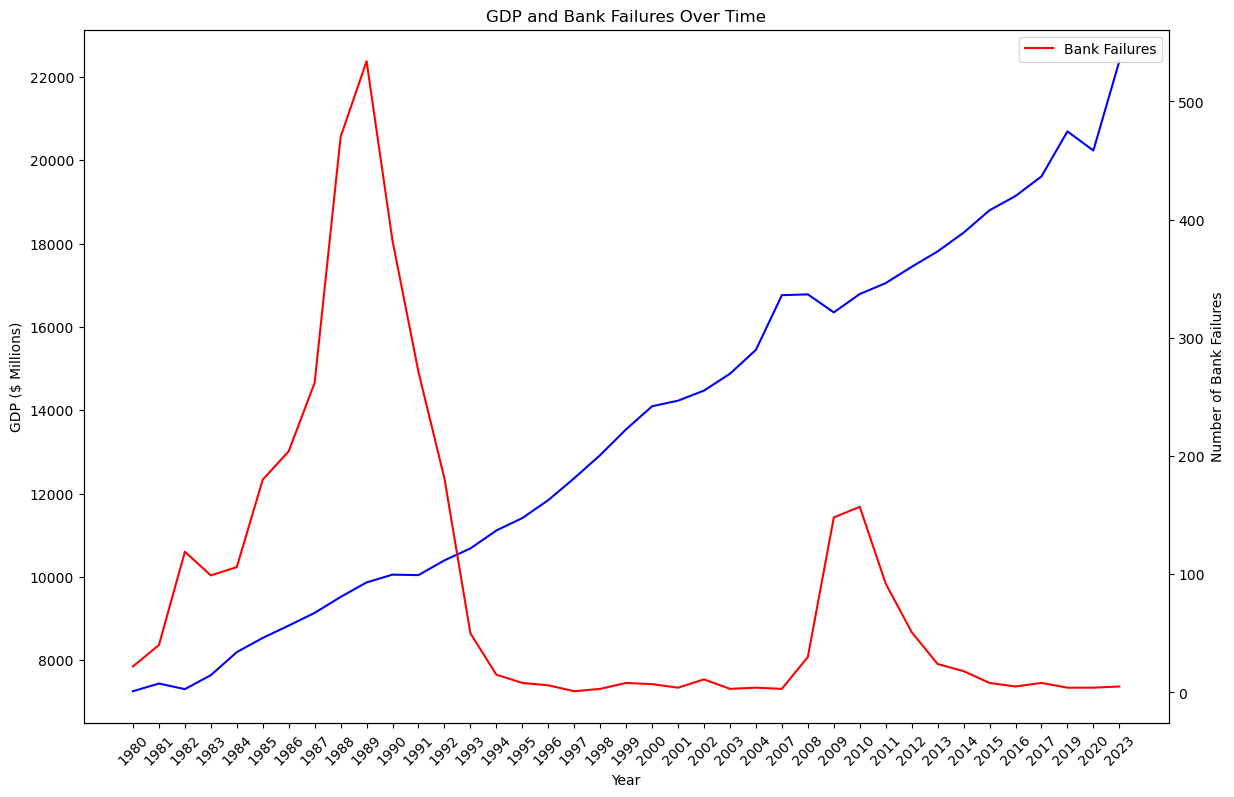

In [ ]:
df['value'] = pd.to_numeric(df['value'], errors='coerce')
df['BANK_FAILURES'] = pd.to_numeric(df['BANK_FAILURES'], errors='coerce')

plt.figure(figsize=(14, 9))
plt.xticks(rotation=45)
plt.plot(df['GDP_DATE'], df['value'], label='GDP ($ Millions)', color='blue')
plt.xlabel('Year')
plt.ylabel('GDP ($ Millions)')
plt.twinx()  # Create a second y-axis
plt.xticks(rotation=45)
plt.plot(df['GDP_DATE'], df['BANK_FAILURES'], label='Bank Failures', color='red')
plt.ylabel('Number of Bank Failures')
plt.title('GDP and Bank Failures Over Time')
plt.legend()
plt.show()

In [ ]:
correlation = df['value'].corr(df['BANK_FAILURES'])
print(f"The correlation coefficient between GDP and bank failures is: {correlation}")


The correlation coefficient between GDP and bank failures is: -0.4681847373846146


### Objective:
The regression analysis aims to understand the relationship between GDP growth amd the number of bank failuresover the years 1980 to 2023. 

In [ ]:
import statsmodels.api as sm

df['value'] = pd.to_numeric(df['value'], errors='coerce')
df['BANK_FAILURES'] = pd.to_numeric(df['BANK_FAILURES'], errors='coerce')
# Linear regression
X = sm.add_constant(df['value'])  # adding a constant
model = sm.OLS(df['BANK_FAILURES'], X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          BANK_FAILURES   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     10.39
Date:                Wed, 07 Aug 2024   Prob (F-statistic):            0.00265
Time:                        20:07:05   Log-Likelihood:                -240.91
No. Observations:                  39   AIC:                             485.8
Df Residuals:                      37   BIC:                             489.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        286.4109     63.602      4.503      0.0

### **Key Findings**
#### **1. Model Overview:** 
The **Dependent Variable** is *Bank Failures*, the **Independent Variable** is *GDP growth* and there are 39 number of observations.

#### **2. Model Performance:**
**R-squared**

* The *R-squared* value of 0.219 indicates that approximately 21.9% of the variance in the number of bank failures is explained by the model. *Adjusted R-squared* for the number of predictors, about 19.8%.

**F-statistic**

* The model is statistic with a p-value of 0.00265, suggesting that the model provides a better fit than a model with no predictors.

#### **3. Coefficients:**

**Constant(Intercept):** 283.4109
* This intercept represents that when the GDP is zero, the expected number of bank failures is approximately 286. This is a theoretical value primarily anchoring the regression line.

**GDP (value):** -0.0144
* For each one million dollar increase in GDP, there is a 1.44% unit decrease in the number of bank failures. The negative sign indicates an inverse relationship between GDP growth and bank failures.

#### **4. Statistically Significance:**
* The **p-value** for the GDP coefficient (0.003) shows that the relationship between GDP and bank failures is statistically significant at the 0.01 level.

#### **5. Potential Issues:**
* **Multicollearity:** The large condition number (47300) suggests potential multicollinearity issues.
* **Autocorrelation:** The Durbin-Watson statistic points to positive autocorrelation, which can impact the models effectiveness.

### **Recommendations:**
#### Further Analysis:
* Addressing the potential issues such as autocorrelation, multicollinearity, and non-normality of residuals.
* Adding additional economic indicators such as unemployment rates, interest rates, and inflation rates to capture a broader range of factors influencing bank failures.
* We can seek to use more models to better handle the time dependent nature of the data and to improve the predictive accuracy.











